Install and import required libraries

## Package Installation
Installing essential libraries for transformer-based models and fine-tuning:
- `transformers`: Hugging Face's library for state-of-the-art NLP models
- `datasets`: Library for easily accessing and processing datasets
- `evaluate`: Tools for model evaluation
- `accelerate`: Enables distributed training and mixed precision
- `peft`: Parameter-Efficient Fine-Tuning methods
- `trl`: Transformer Reinforcement Learning
- `bitsandbytes`: Quantization and memory optimization
### NVIDIA GPU Monitoring
Installing NVIDIA ML Python bindings for GPU monitoring and management
### Model Architecture Visualization
Installing torchinfo for visualizing PyTorch model architectures and parameters

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
!pip install torchinfo


## Library Imports and Setup

This cell imports all necessary Python libraries for our fine-tuning project:

1. **Standard Python Libraries**
   - Basic file operations (`os`)
   - Data serialization (`pickle`)
   - Random number generation (`random`)
   - Special collections (`defaultdict`)

2. **Data Processing & Visualization**
   - NumPy for numerical operations
   - Pandas for data manipulation
   - Matplotlib and Seaborn for creating visualizations

3. **PyTorch Ecosystem**
   - Core PyTorch functionality
   - DataLoader for batch processing
   - Model architecture visualization (torchinfo)
   - Progress bars with tqdm

4. **Hugging Face Tools**
   - Dataset handling and loading
   - RoBERTa model and tokenizer
   - Training infrastructure (Trainer, TrainingArguments)
   - Data collation utilities

5. **PEFT (Parameter Efficient Fine-Tuning)**
   - LoRA configuration and model adaptation
   - Task-specific PEFT utilities

6. **Evaluation Tools**
   - Metrics calculation (accuracy, precision, recall, F1)
   - Classification report generation
   - Tabulated results display

In [2]:
# Standard libraries
import os
import pickle
import random
from collections import defaultdict

# Data processing and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and related utilities
import torch
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm import tqdm

# Hugging Face Datasets and Transformers
from datasets import load_dataset, Dataset, ClassLabel
from transformers import (
    RobertaModel,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    get_scheduler
)

# PEFT (Parameter Efficient Fine-Tuning)
from peft import LoraConfig, get_peft_model, PeftModel, TaskType

# Evaluation and metrics
import evaluate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from tabulate import tabulate


## Load Tokenizer and Preprocess Data

## Data Preparation and Tokenization

This cell sets up our model and prepares the AG News dataset for training:

1. **Model Selection**
   - Using RoBERTa-base as our foundation model
   - RoBERTa is a robustly optimized BERT variant known for strong performance

2. **Dataset Loading**
   - Loading the AG News dataset from Hugging Face's datasets library
   - Using the training split for our fine-tuning

3. **Tokenization Setup**
   - Initializing RoBERTa tokenizer
   - The tokenizer converts text into tokens that the model can understand

4. **Data Processing**
   - Custom preprocessing function to tokenize text data
   - Handles truncation and padding automatically
   - Converts dataset format to be compatible with transformer training
   - Renames 'label' column to 'labels' for compatibility with Transformers

In [3]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

## Label Processing and Data Collation Setup

This cell handles the dataset's label information and sets up data batching:

1. **Label Information Extraction**
   - Determines the number of classes in the AG News dataset
   - Extracts the class names/categories
   - AG News is a news classification dataset with multiple categories

2. **Label Mapping Creation**
   - Creates a dictionary mapping from numeric indices to label names
   - Essential for interpreting model predictions later
   - Helps maintain consistency between numeric and text representations of categories

3. **Data Collation Configuration**
   - Sets up a collator that will handle batching of data
   - Ensures proper padding of sequences within each batch
   - Converts data to PyTorch tensors for model input
   - Handles variable length sequences efficiently

In [4]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

## Model Initialization

This cell initializes our RoBERTa model for sequence classification:

1. **Model Configuration**
   - Uses RoBERTa-base pretrained model
   - Adapts it for sequence classification task
   - Configures the model with our custom label mapping (id2label)

2. **Architecture**
   - Built on RoBERTa's transformer architecture
   - Adds a classification head on top of the base model
   - Automatically configures output dimensions for our multi-class task

3. **Model Display**
   - Prints model architecture summary
   - Shows parameter count and layer structure

In [5]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

# ENVIRONMENT SETUP AND CONFIGURATION

## Environment and Competition Setup

This cell configures the training environment and handles competition data:

1. **Constants Definition**
   - Sets maximum trainable parameters (1M) as per project requirements
   - Defines environment flag for Kaggle/local execution

2. **Environment Detection**
   - Automatically detects whether code is running on Kaggle or locally
   - Provides different execution paths based on environment

3. **Kaggle Integration**
   - Handles Kaggle authentication if running on Kaggle platform
   - Downloads competition data automatically
   - Extracts competition files for use
   - Project: Deep Learning Spring 2025 - Project 2

4. **Error Handling**
   - Gracefully handles non-Kaggle environments
   - Ensures code can run both locally and on Kaggle

In [6]:
print("\n" + "="*80)
print("SETTING UP ENVIRONMENT")
print("="*80)

# Define constants
MAX_TRAINABLE_PARAMS = 1_000_000  
KAGGLE_ENV = False  # Set to True when running on Kaggle

# Check if running on Kaggle
try:
    import kagglehub
    KAGGLE_ENV = True
    print("Running in Kaggle environment")
    
    # Login to Kaggle
    print("Logging in to Kaggle...")
    kagglehub.login()
    
    # Download competition data
    print("Downloading competition data...")
    !kaggle competitions download -c deep-learning-spring-2025-project-2
    !unzip -q deep-learning-spring-2025-project-2.zip
    
    print("✅ Competition data downloaded and extracted")
except ImportError:
    print("Running in non-Kaggle environment")


SETTING UP ENVIRONMENT
Running in non-Kaggle environment


# Device configuration (CPU/MPS/GPU)

## Hardware Acceleration Setup

This cell configures the computational device for model training:

1. **Device Detection**
   - Automatically detects available hardware accelerators
   - Supports multiple platforms:
     - Google TPU (via XLA)
     - Apple Silicon GPU (MPS)
     - NVIDIA GPU (CUDA)
     - CPU (fallback option)

2. **Device Assignment**
   - Prioritizes fastest available computing device
   - Ensures optimal training performance
   - Handles cross-platform compatibility

3. **Model Deployment**
   - Moves the model to the selected device
   - Prepares for GPU-accelerated training if available
   - Confirms successful device assignment

In [7]:
if "XRT_TPU_CONFIG" in os.environ:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()  # TPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")  # CPU
print(f"Using device: {device} for model training and inference")

# Move model to GPU if available
model.to(device)
print("✅ Base model initialized and moved to device")

Using device: cuda for model training and inference


✅ Base model initialized and moved to device


# Parameter Check

## Model Parameter Analysis

This cell analyzes the model's parameter count and trainability:

1. **Parameter Count**
   - Calculates total number of parameters in the base model
   - Important for understanding model complexity
   - Helps ensure compliance with 1M trainable parameter limit

2. **Trainability Check**
   - Verifies which parameters are set for training
   - Confirms if all parameters are trainable
   - Essential for understanding model's training capacity

3. **Project Requirements**
   - Helps monitor compliance with project constraints
   - Base for planning parameter-efficient fine-tuning strategies

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in base model: {total_params:,}")
print(f"All parameters trainable: {all(p.requires_grad for p in model.parameters())}")

Total parameters in base model: 124,648,708
All parameters trainable: True


# DATA FILTERING

## Data Filtering and Preprocessing

This cell implements a data quality filtering strategy:

1. **Text Length Filtering**
   - Removes outlier examples based on word count
   - Keeps articles between 10 and 200 words
   - Ensures consistent input length for better training

2. **Filtering Function**
   - Custom function to process dataset in batches
   - Maintains all features while filtering examples
   - Provides detailed statistics about filtered data
   - Preserves dataset structure and label information

3. **Dataset Statistics**
   - Tracks original and filtered dataset sizes
   - Reports number of removed examples
   - Helps monitor data quality and quantity

4. **Quality Control**
   - Removes very short texts that might lack context
   - Removes very long texts that might be computational bottlenecks
   - Improves training efficiency and model performance

In [9]:
print("\n" + "="*80)
print("IMPLEMENTING DATA FILTERING STRATEGY")
print("="*80)

# Function to filter out very short and very long examples
def filter_dataset(examples):
    """Filter out examples with very short or very long text."""
    text_lengths = [len(t.split()) for t in examples["text"]]
    
    # Keep examples with word count between 15 and 150 words
    valid_indices = [i for i, length in enumerate(text_lengths) if 20 <= length <= 70]
    
    # Calculate statistics for reporting
    filtered_count = len(text_lengths) - len(valid_indices)
    filtered_percentage = (filtered_count / len(text_lengths)) * 100
    
    print(f"Filtered {filtered_count} examples ({filtered_percentage:.2f}% of the batch)")
    
    return {k: [examples[k][i] for i in valid_indices] for k in examples}

# Apply filtering to the training set only
filtered_train = dataset.map(
    filter_dataset, 
    batched=True, 
    desc="Filtering training data"
)

print(f"Original training set size: {len(dataset)}")
print(f"Filtered training set size: {len(filtered_train)}")
print(f"Removed {len(dataset) - len(filtered_train)} examples")


IMPLEMENTING DATA FILTERING STRATEGY
Original training set size: 120000
Filtered training set size: 116680
Removed 3320 examples


# Tokenize filtered dataset

## Dataset Tokenization

This cell processes the filtered dataset into model-ready format:

1. **Tokenization Process**
   - Applies the previously defined preprocessing function
   - Converts text to token IDs that the model can understand
   - Processes data in batches for efficiency

2. **Data Cleanup**
   - Removes original text column after tokenization
   - Keeps only the necessary tokenized features
   - Optimizes memory usage

3. **Label Standardization**
   - Renames 'label' column to 'labels'
   - Ensures compatibility with Hugging Face's trainer
   - Maintains consistency with transformer library expectations

In [10]:
filtered_tokenized = filtered_train.map(
    preprocess, 
    batched=True,  
    remove_columns=["text"]
)
filtered_tokenized = filtered_tokenized.rename_column("label", "labels")

## Anything from here on can be modified

## Train-Test Split

This cell divides the processed dataset into training and evaluation sets:

1. **Dataset Division**
   - Splits tokenized dataset into training and test sets
   - Uses fixed test size of 640 examples
   - Maintains reproducibility with seed=42

2. **Split Configuration**
   - Training set: Majority of data for model learning
   - Evaluation set: Fixed size for consistent testing
   - Random but deterministic splitting

3. **Purpose**
   - Enables proper model evaluation
   - Prevents overfitting assessment
   - Creates separate datasets for training and testing

In [11]:
# Split the original training set
split_datasets = filtered_tokenized.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

# Dataset Visualization

## Dataset Visualization and Analysis

This cell creates comprehensive visualizations and analysis of the dataset:

1. **Class Distribution Analysis**
   - Creates bar plot of class frequencies
   - Shows distribution across all categories
   - Helps identify potential class imbalance
   - Saves visualization as 'class_distribution.png'

2. **Text Length Analysis**
   - Generates histogram of text lengths
   - Shows distribution of word counts
   - Marks median and 95th percentile
   - Helps understand text length patterns
   - Saves visualization as 'text_length_distribution.png'

3. **Sample Exploration**
   - Displays random examples from each class
   - Shows first 150 characters of each sample
   - Provides qualitative insight into data
   - Helps understand typical content per class

4. **Visualization Features**
   - Uses Seaborn and Matplotlib for clear plots
   - Includes proper labels and titles
   - Saves plots for future reference
   - Ensures reproducible analysis


DATASET VISUALIZATION AND EXPLORATION


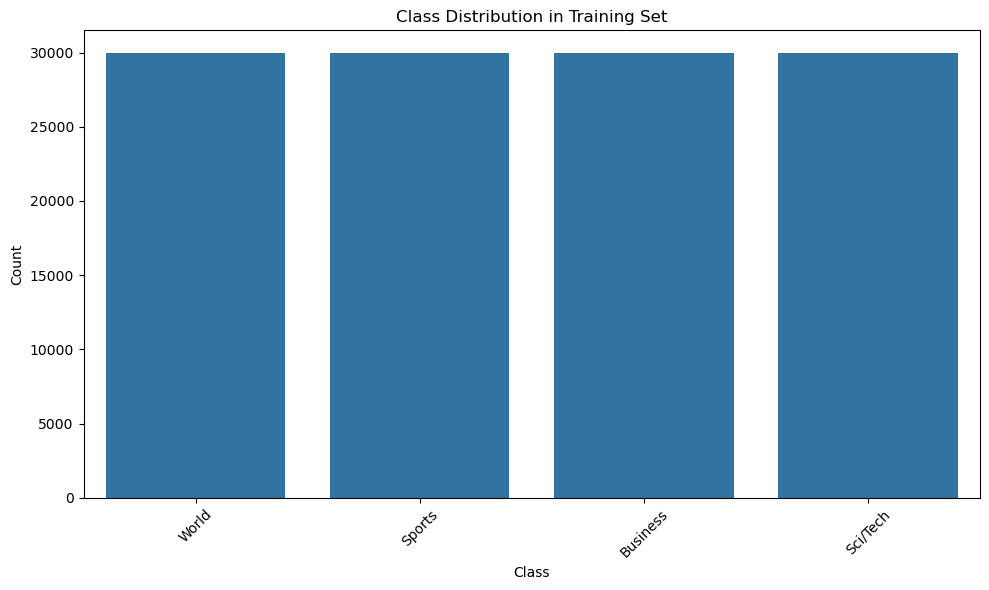

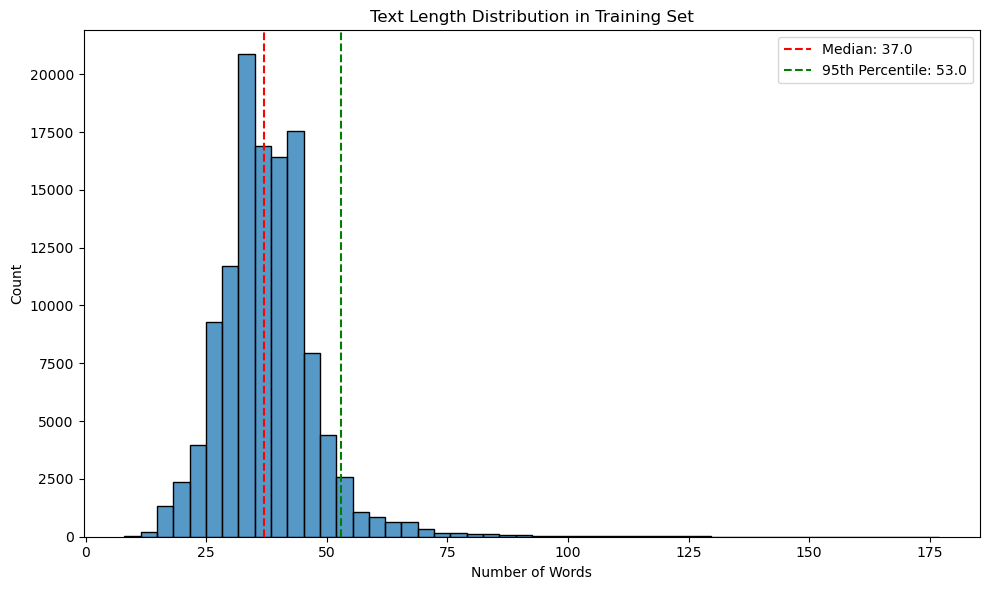


Sample examples from each class:



Class 0: World
  Example 1: Barghouti withdraws from race replace Arafat RAMALLAH, West Bank - Marwan Barghouti, the imprisoned leader of the Palestinian uprising, is dropping ou...
  Example 2: Suu Kyi Proves Tricky Topic for Asia-Europe Summit  HANOI (Reuters) - Leaders from Asia and Europe pledged on  Saturday to tackle everything from clim...



Class 1: Sports
  Example 1: In Game 2, It #39;s Bloopers: The Sequel At the rate the Boston Red Sox are going, they will soon be selling their World Series highlight film, which ...
  Example 2: Paul McCartney to Headline Super Bowl Show (AP) AP - Paul McCartney will headline the Super Bowl halftime show on Feb. 6 as the NFL goes mainstream af...



Class 2: Business
  Example 1: Air China inaugural flight lands at Dubai International Airport The Department of Civil Aviation Dubai, last night welcomed the inaugural Air China fl...
  Example 2: Jeremy Warner #39;s Outlook: No hurricane yet as IMF warns on house &lt;b&gt;...&lt;/b&gt; The International Monetary Fund is worrying about the UK ho...



Class 3: Sci/Tech
  Example 1: Yahoo Builds the Yahoo Search Blog Yahoo Builds the Yahoo Search Blog\\When I logged on this morning and checked my daily referral stats I noticed a m...
  Example 2: Phishing on the increase Online phishing schemes increased significantly in October as financial institutions struggled to combat attempts to steal pr...


In [12]:
print("\n" + "="*80)
print("DATASET VISUALIZATION AND EXPLORATION")
print("="*80)

# 1. Plot class distribution
plt.figure(figsize=(10, 6))
class_counts = dataset.to_pandas()['label'].value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(class_counts.index, [class_names[i] for i in class_counts.index], rotation=45)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# 2. Text length distribution
text_lengths = [len(text.split()) for text in dataset['text']]
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=50)
plt.title('Text Length Distribution in Training Set')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.axvline(x=np.median(text_lengths), color='r', linestyle='--', label=f'Median: {np.median(text_lengths)}')
plt.axvline(x=np.percentile(text_lengths, 95), color='g', linestyle='--', label=f'95th Percentile: {np.percentile(text_lengths, 95)}')
plt.legend()
plt.tight_layout()
plt.savefig('text_length_distribution.png')
plt.show()

# 3. Display sample examples from each class
print("\nSample examples from each class:")
samples_per_class = {}
for i, class_name in enumerate(class_names):
    class_examples = [ex for ex in dataset if ex['label'] == i]
    samples = random.sample(class_examples, min(2, len(class_examples)))
    samples_per_class[class_name] = samples
    
    print(f"\nClass {i}: {class_name}")
    for j, sample in enumerate(samples):
        print(f"  Example {j+1}: {sample['text'][:150]}...")


## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

## LoRA (Low-Rank Adaptation) Configuration

This cell sets up and tests different LoRA configurations for parameter-efficient fine-tuning:

1. **Configuration Options**
   - Minimal: Basic adaptation with query-only modifications
   - Balanced: Moderate adaptation targeting query and value layers
   - Comprehensive: Full adaptation of attention mechanism (query, key, value)

2. **Configuration Testing**
   - Tests each configuration against parameter limit (1M)
   - Calculates trainable parameters
   - Computes percentage of trainable parameters
   - Verifies compliance with project constraints

3. **Configuration Parameters**
   - `r`: Rank of LoRA adaptation
   - `lora_alpha`: Scaling factor for LoRA
   - `lora_dropout`: Dropout rate for regularization
   - `target_modules`: Which transformer components to adapt

4. **Selection Logic**
   - Filters configurations under parameter limit
   - Selects configuration with maximum parameters within limit
   - Ensures optimal use of available parameter budget
   - Raises error if no valid configurations found

In [13]:
print("\n" + "="*80)
print("CONFIGURING LoRA ADAPTATION")
print("=" * 80)

# PEFT Config
lora_configs = [
    # Configuration 1: Similar to starter notebook with minimal adaptation
    {
        "name": "minimal",
        "r": 2,
        "lora_alpha": 16,
        "lora_dropout": 0.05,
        "target_modules": ["query"],
    },
    # Configuration 2: More extensive adaptation
    {
        "name": "balanced", 
        "r": 3,
        "lora_alpha": 32,
        "lora_dropout": 0.1,
        "target_modules": ["query", "value"],
    },
    # Configuration 3: Comprehensive adaptation (might exceed parameter limit)
    {
        "name": "comprehensive",
        "r": 4, 
        "lora_alpha": 96,
        "lora_dropout": 0.1,
        "target_modules": ["query", "key", "value"],
    },
    # Configuration 4: Focused adaptation with strong rank
    {
        "name": "focused_strong",
        "r": 2,  
        "lora_alpha": 128,  
        "lora_dropout": 0.15,  
        "target_modules": ["query", "key", "value"],
    }
]

# Function to test if a configuration stays under the parameter limit
def test_lora_config(config):
    """Test if a LoRA configuration stays under the parameter limit."""
    print(f"\nTesting configuration: {config['name']}")
    print(f"  - rank (r): {config['r']}")
    print(f"  - alpha: {config['lora_alpha']}")
    print(f"  - target modules: {config['target_modules']}")

    # Create LoRA configuration
    lora_config = LoraConfig(
        r=config["r"],
        lora_alpha=config["lora_alpha"],
        lora_dropout=config["lora_dropout"],
        bias="none",
        target_modules=config["target_modules"],
        task_type=TaskType.SEQ_CLS,
    )

    # Get PEFT model
    peft_model = get_peft_model(model, lora_config)

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in peft_model.parameters())
    trainable_percentage = 100 * trainable_params / total_params

    print(f"  - Trainable parameters: {trainable_params:,}")
    print(f"  - Total parameters: {total_params:,}")
    print(f"  - Trainable percentage: {trainable_percentage:.2f}%")

    # Check if under limit
    under_limit = trainable_params < MAX_TRAINABLE_PARAMS
    print(f"  - Under {MAX_TRAINABLE_PARAMS:,} parameter limit: {'✅' if under_limit else '❌'}")

    return {
        "config": config,
        "trainable_params": trainable_params,
        "under_limit": under_limit,
        "peft_config": lora_config
    }

# Test all configurations
config_results = [test_lora_config(config) for config in lora_configs]

# Filter valid configurations
valid_configs = [result for result in config_results if result["under_limit"]]

# Select the configuration with the most parameters (within limit)
selected_config = max(valid_configs, key=lambda x: x["trainable_params"])


CONFIGURING LoRA ADAPTATION

Testing configuration: minimal
  - rank (r): 2
  - alpha: 16
  - target modules: ['query']


  - Trainable parameters: 630,532
  - Total parameters: 125,279,240
  - Trainable percentage: 0.50%
  - Under 1,000,000 parameter limit: ✅

Testing configuration: balanced
  - rank (r): 3
  - alpha: 32
  - target modules: ['query', 'value']
  - Trainable parameters: 704,260
  - Total parameters: 125,352,968
  - Trainable percentage: 0.56%
  - Under 1,000,000 parameter limit: ✅

Testing configuration: comprehensive
  - rank (r): 4
  - alpha: 96
  - target modules: ['query', 'key', 'value']
  - Trainable parameters: 814,852
  - Total parameters: 125,463,560
  - Trainable percentage: 0.65%
  - Under 1,000,000 parameter limit: ✅

Testing configuration: focused_strong
  - rank (r): 2
  - alpha: 128
  - target modules: ['query', 'key', 'value']
  - Trainable parameters: 704,260
  - Total parameters: 125,352,968
  - Trainable percentage: 0.56%
  - Under 1,000,000 parameter limit: ✅


/ext3/miniconda3/lib/python3.12/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/ext3/miniconda3/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


## LoRA Model Initialization and Verification

This cell finalizes the LoRA setup and performs crucial verification:

1. **Selected Configuration Summary**
   - Displays chosen LoRA configuration name
   - Shows number of trainable parameters
   - Provides clear overview of adaptation strategy

2. **Model Creation**
   - Initializes PEFT model with selected LoRA config
   - Moves model to appropriate device (CPU/GPU/TPU)
   - Applies parameter-efficient fine-tuning setup

3. **Parameter Verification**
   - Double-checks trainable parameter count
   - Verifies total parameter count
   - Ensures compliance with 1M parameter limit
   - Provides detailed parameter statistics

4. **Safety Checks**
   - Asserts parameter count is within limits
   - Confirms successful model initialization
   - Validates hardware deployment
   - Provides clear success/failure indicators

In [14]:
print("\n" + "-"*50)
print(f"Selected LoRA configuration: {selected_config['config']['name']}")
print(f"Trainable parameters: {selected_config['trainable_params']:,}")
print("-"*50)

# Create the final LoRA model with the selected configuration
peft_config = selected_config["peft_config"]
peft_model = get_peft_model(model, peft_config)
peft_model.to(device)

# Verify parameters again
print("\nFinal model parameter verification:")
peft_model.print_trainable_parameters()

# Double-check trainable parameters
final_total_params = sum(p.numel() for p in peft_model.parameters())
print(f"Final total parameters in PEFT model: {final_total_params:,}")
final_trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
print(f"Final trainable parameters in PEFT model: {final_trainable_params:,}")
assert final_trainable_params < MAX_TRAINABLE_PARAMS, f"❌ Model exceeds parameter limit with {final_trainable_params:,} trainable parameters!"
print(
    f"✅ Final check passed! Model has {final_trainable_params:,} trainable parameters (limit: {MAX_TRAINABLE_PARAMS:,})"
)


--------------------------------------------------
Selected LoRA configuration: comprehensive
Trainable parameters: 814,852
--------------------------------------------------



Final model parameter verification:
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495
Final total parameters in PEFT model: 125,463,560
Final trainable parameters in PEFT model: 814,852
✅ Final check passed! Model has 814,852 trainable parameters (limit: 1,000,000)


# Select the configuration with the most parameters (within limit)

# Select the configuration with the most parameters (within limit)

## Training Setup

## Training and Evaluation Metrics Setup

This cell configures the training process and defines evaluation metrics:

1. **Optimizer Selection**
   - Uses RMSprop optimizer
   - Alternative options include AdamW and SGD
   - Chosen for its adaptive learning rate properties

2. **Metrics Configuration**
   - Implements comprehensive evaluation metrics:
     - Accuracy: Overall classification correctness
     - Precision: Measure of prediction quality
     - Recall: Measure of prediction completeness
     - F1-Score: Harmonic mean of precision and recall

3. **Per-Class Analysis**
   - Calculates metrics for each class separately
   - Enables detailed performance analysis
   - Helps identify class-specific issues
   - Uses weighted averages for imbalanced classes

4. **Evaluation Function**
   - Custom `compute_metrics` function for 🤗 Trainer
   - Processes model predictions and ground truth
   - Returns both aggregate and per-class metrics
   - Facilitates detailed model performance tracking

In [15]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("\n" + "="*80)
print("CONFIGURING TRAINING")
print("=" * 80)

SELECTED_OPTIMIZER = "adamw"  # Options: "adamw", "sgd", "rmsprop"
print(f"Selected optimizer: {SELECTED_OPTIMIZER}")

def compute_metrics(eval_pred):
    """Calculate multiple metrics for model evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate various metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    # Calculate per-class metrics
    per_class_precision = precision_score(labels, predictions, average=None)
    per_class_recall = recall_score(labels, predictions, average=None)
    per_class_f1 = f1_score(labels, predictions, average=None)

    # Prepare results
    results = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

    # Add per-class metrics
    for i, class_name in id2label.items():
        results[f"precision_{class_name}"] = per_class_precision[i]
        results[f"recall_{class_name}"] = per_class_recall[i]
        results[f"f1_{class_name}"] = per_class_f1[i]

    return results


CONFIGURING TRAINING
Selected optimizer: adamw


In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,  
    per_device_train_batch_size=48,  
    per_device_eval_batch_size=64,
    num_train_epochs=25,  
    weight_decay=0.005,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    learning_rate=1e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.15,
    optim="adamw_torch",
    logging_dir="./logs",
    logging_steps=50,  
    gradient_checkpointing=False,
    label_smoothing_factor=0.05,
    fp16=True,
    gradient_accumulation_steps=2,  
    gradient_checkpointing_kwargs={'use_reentrant': True}
)

# Custom Trainer class for tracking training history

## Custom Trainer Implementation

This cell extends Hugging Face's Trainer class with enhanced monitoring and visualization:

1. **Custom Trainer Class**
   - Inherits from 🤗 Trainer
   - Adds history tracking for metrics
   - Implements custom logging functionality
   - Enables detailed training visualization

2. **Metric Tracking**
   - Records training metrics over time:
     - Training loss
     - Learning rate
     - Accuracy
     - Custom evaluation metrics
   - Maintains separate histories for training and evaluation
   - Tracks steps and epochs

3. **Visualization Features**
   - Creates comprehensive training plots:
     - Training loss curve
     - Accuracy comparison (train vs validation)
     - Learning rate progression
     - Additional metric trends
   - Saves plots as 'training_metrics.png'
   - Provides real-time training insights

4. **Reporting**
   - Prints final training metrics
   - Shows evaluation results
   - Provides detailed performance summary
   - Enables easy model performance analysis

In [17]:
class CustomTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_history = defaultdict(list)
        self.eval_history = defaultdict(list)
        self.step_history = []
        self.epoch_history = []

    def log(self, logs, start_time=None):
        # Note: Added start_time parameter to match parent class
        super().log(logs, start_time)

        # Track training metrics
        for key, value in logs.items():
            if key.startswith("train_"):
                self.train_history[key].append(float(value))
            elif key.startswith("eval_"):
                self.eval_history[key].append(float(value))

        # Track steps and epochs
        if "epoch" in logs:
            self.epoch_history.append(float(logs["epoch"]))
        if "step" in logs:
            self.step_history.append(int(logs["step"]))

    def plot_metrics(self):
        """Plot training and evaluation metrics."""
        if not self.step_history:
            print("No training history to plot.")
            return

        # Plot training loss
        plt.figure(figsize=(12, 8))

        if "train_loss" in self.train_history:
            plt.subplot(2, 2, 1)
            plt.plot(self.step_history,
                     self.train_history["train_loss"],
                     label="Train")
            plt.title("Training Loss")
            plt.xlabel("Step")
            plt.ylabel("Loss")
            plt.legend()

        # Plot accuracy
        plt.subplot(2, 2, 2)

        # Plot train accuracy if available
        if "train_accuracy" in self.train_history:
            plt.plot(self.step_history,
                     self.train_history["train_accuracy"],
                     label="Train")

        # Plot eval accuracy
        # eval_steps = self.step_history[::len(self.step_history)//len(self.eval_history["eval_accuracy"])][:len(self.eval_history["eval_accuracy"])]
        if self.eval_history.get("eval_accuracy", []):
            step_interval = max(1, len(self.step_history) // len(self.eval_history["eval_accuracy"]))
            eval_steps = self.step_history[::step_interval][:len(self.eval_history["eval_accuracy"])]
        else:
            eval_steps = []

        plt.plot(eval_steps,
                 self.eval_history["eval_accuracy"],
                 label="Validation",
                 marker="o")
        plt.title("Model Accuracy")
        plt.xlabel("Step")
        plt.ylabel("Accuracy")
        plt.legend()

        # Plot learning rate
        if "learning_rate" in self.train_history:
            plt.subplot(2, 2, 3)
            plt.plot(self.step_history, self.train_history["learning_rate"])
            plt.title("Learning Rate")
            plt.xlabel("Step")
            plt.ylabel("LR")

        # Plot eval metrics
        plt.subplot(2, 2, 4)
        for key, values in self.eval_history.items():
            if key != "eval_accuracy" and key != "eval_loss" and len(
                    values) > 0:
                plt.plot(eval_steps, values, label=key.replace("eval_", ""))

        if len(plt.gca().get_lines()) > 0:
            plt.title("Additional Metrics")
            plt.xlabel("Step")
            plt.ylabel("Score")
            plt.legend()
        else:
            plt.title("No Additional Metrics")

        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()

        # Print final metrics
        print("\nFinal Training Metrics:")
        for key, values in self.train_history.items():
            if len(values) > 0:
                print(f"  {key}: {values[-1]:.4f}")

        print("\nFinal Evaluation Metrics:")
        for key, values in self.eval_history.items():
            if len(values) > 0:
                print(f"  {key}: {values[-1]:.4f}")

# get_trainer function uses CustomTrainer

## Trainer Initialization

This cell creates and configures the custom training instance:

1. **Trainer Setup**
   - Uses our CustomTrainer class with enhanced monitoring
   - Connects all training components:
     - LoRA-adapted model
     - Training arguments
     - Training and evaluation datasets
     - Tokenizer
     - Data collator
     - Metrics computation

2. **Components Integration**
   - Binds model with datasets
   - Incorporates custom metrics
   - Sets up data processing pipeline
   - Prepares for training execution

3. **Training Pipeline**
   - Establishes end-to-end training workflow
   - Handles data batching and processing
   - Manages model updates and evaluation
   - Enables metric tracking and visualization

In [18]:
# Initialize trainer
trainer = CustomTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("✅ Training configuration complete")

/tmp/ipykernel_5493/2030041325.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Training configuration complete


# Start Training

In [19]:
print("\n" + "="*80)
print("STARTING MODEL TRAINING")
print("="*80)

# Start training
trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)

# Save the model
output_dir = "./saved_model"
os.makedirs(output_dir, exist_ok=True)

# Save model, configuration, and tokenizer
peft_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Model saved to {output_dir}")


STARTING MODEL TRAINING


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision World,Recall World,F1 World,Precision Sports,Recall Sports,F1 Sports,Precision Business,Recall Business,F1 Business,Precision Sci/tech,Recall Sci/tech,F1 Sci/tech
1,0.421300,0.396420,0.929688,0.930337,0.929688,0.928640,0.928105,0.940397,0.934211,0.982036,0.993939,0.987952,0.924242,0.807947,0.862191,0.888298,0.965318,0.925208
2,0.375200,0.356298,0.946875,0.946871,0.946875,0.946860,0.953333,0.947020,0.950166,0.993939,0.993939,0.993939,0.906667,0.900662,0.903654,0.931429,0.942197,0.936782
3,0.362200,0.346532,0.951562,0.952104,0.951562,0.951282,0.953642,0.953642,0.953642,0.987879,0.987879,0.987879,0.950000,0.880795,0.914089,0.918478,0.976879,0.946779
4,0.349100,0.341442,0.953125,0.953059,0.953125,0.952914,0.953947,0.960265,0.957096,0.987952,0.993939,0.990937,0.937500,0.894040,0.915254,0.932584,0.959538,0.945869
5,0.330600,0.337689,0.950000,0.949898,0.950000,0.949807,0.947368,0.953642,0.950495,0.993939,0.993939,0.993939,0.924138,0.887417,0.905405,0.932584,0.959538,0.945869
6,0.329900,0.337494,0.948438,0.948906,0.948438,0.948362,0.953020,0.940397,0.946667,0.993865,0.981818,0.987805,0.931034,0.894040,0.912162,0.918033,0.971098,0.943820
7,0.320400,0.333341,0.945312,0.945314,0.945312,0.945271,0.934641,0.947020,0.940789,0.987805,0.981818,0.984802,0.918919,0.900662,0.909699,0.937143,0.947977,0.942529
8,0.326900,0.331031,0.953125,0.953287,0.953125,0.953079,0.941558,0.960265,0.950820,0.993865,0.981818,0.987805,0.938356,0.907285,0.922559,0.937853,0.959538,0.948571
9,0.314100,0.332623,0.953125,0.952944,0.953125,0.952915,0.947712,0.960265,0.953947,0.993976,1.000000,0.996979,0.931034,0.894040,0.912162,0.937500,0.953757,0.945559
10,0.306900,0.334124,0.946875,0.946806,0.946875,0.946818,0.953020,0.940397,0.946667,0.993976,1.000000,0.996979,0.906667,0.900662,0.903654,0.931429,0.942197,0.936782



TRAINING COMPLETE


✅ Model saved to ./saved_model


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

## Custom Text Classification Function

This cell implements a function for real-world model inference:

1. **Classification Function**
   - Takes three inputs:
     - Trained model
     - Tokenizer
     - Text to classify
   - Returns predicted class label

2. **Processing Pipeline**
   - Automatically selects appropriate device (CPU/GPU)
   - Tokenizes input text
   - Handles padding and truncation
   - Converts inputs to PyTorch tensors

3. **Prediction Output**
   - Processes model outputs
   - Extracts predicted class
   - Maps numeric prediction to human-readable label
   - Provides detailed output including:
     - Numeric class ID
     - Class label
     - Input text

4. **Usage**
   - Enables quick testing of model on new texts
   - Provides immediate feedback on model predictions
   - Useful for model demonstration and validation

In [20]:
print("\n" + "="*80)
print("EVALUATING MODEL ON CUSTOM INPUTS")
print("=" * 80)

def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]


EVALUATING MODEL ON CUSTOM INPUTS


In [21]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlingand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

## Model Evaluation Implementation

This cell implements two different evaluation approaches:

1. **Method 1: Trainer Evaluation**
   - Uses Hugging Face's built-in evaluation
   - Calculates accuracy and other metrics
   - Verifies against 80% accuracy requirement
   - Provides immediate feedback on model performance

2. **Method 2: Custom Evaluation Function**
   - Features:
     - Batch processing for efficiency
     - Progress tracking with tqdm
     - Detailed logging
     - Support for both labeled and unlabeled data
   - Components:
     - DataLoader configuration
     - Device management (CPU/GPU)
     - Memory-efficient inference
     - Metric computation

3. **Evaluation Features**
   - Handles both labeled and unlabeled datasets
   - Provides detailed progress updates
   - Implements error handling
   - Supports custom batch sizes
   - Returns comprehensive metrics

4. **Output Details**
   - Accuracy metrics
   - Prediction arrays
   - Detailed progress logs
   - Performance warnings if needed

In [22]:
print("\n" + "="*80)
print("EVALUATING MODEL")
print("="*80)

eval_results = trainer.evaluate(eval_dataset)
print(f"Evaluation results: {eval_results}")

# Extract evaluation accuracy from the results dictionary
final_eval_accuracy = eval_results.get("eval_accuracy", 0)
print(f"Evaluation Accuracy (Trainer method): {final_eval_accuracy:.4f}")

if final_eval_accuracy < 0.80:
    print(f"⚠️ Warning: The model accuracy ({final_eval_accuracy:.4f}) is below the minimum requirement of 80%")
else:
    print(f"✅ Model meets the minimum accuracy requirement!")

from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.
    
    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches.
    
    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    print(f"Starting evaluation with batch size {batch_size}...")
    print(f"Dataset size: {len(dataset)} examples")
    print(f"Dataset format: {dataset.format}")
    print(f"Evaluation mode: {'Labelled' if labelled else 'Unlabelled'}")
    
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    print(f"Created DataLoader with {len(eval_dataloader)} batches")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    inference_model.to(device)
    inference_model.eval()
    print("Model set to evaluation mode")
    
    all_predictions = []
    if labelled:
        print("Loading accuracy metric for evaluation")
        metric = evaluate.load('accuracy')
    
    # Loop over the DataLoader
    print("Starting inference loop...")
    
    for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc="Running evaluation")):
        # Print batch info occasionally
        if batch_idx % 10 == 0:
            print(f"Processing batch {batch_idx}/{len(eval_dataloader)}")
            
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = inference_model(**batch)
        
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())
        
        if labelled:
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )
    
    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)
    print(f"Completed inference. Total predictions: {len(all_predictions)}")
    
    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions


EVALUATING MODEL


Evaluation results: {'eval_loss': 0.3328428566455841, 'eval_accuracy': 0.95625, 'eval_precision': 0.9563584329974834, 'eval_recall': 0.95625, 'eval_f1': 0.9559660688457781, 'eval_precision_World': 0.9539473684210527, 'eval_recall_World': 0.9602649006622517, 'eval_f1_World': 0.9570957095709571, 'eval_precision_Sports': 0.9939393939393939, 'eval_recall_Sports': 0.9939393939393939, 'eval_f1_Sports': 0.9939393939393939, 'eval_precision_Business': 0.9436619718309859, 'eval_recall_Business': 0.8874172185430463, 'eval_f1_Business': 0.9146757679180887, 'eval_precision_Sci/Tech': 0.9337016574585635, 'eval_recall_Sci/Tech': 0.976878612716763, 'eval_f1_Sci/Tech': 0.9548022598870056, 'eval_runtime': 0.7066, 'eval_samples_per_second': 905.742, 'eval_steps_per_second': 14.152, 'epoch': 25.0}
Evaluation Accuracy (Trainer method): 0.9563
✅ Model meets the minimum accuracy requirement!


# Check evaluation accuracy

## Evaluation Methods Comparison

This cell compares different evaluation approaches to ensure result consistency:

1. **Evaluation**
   - Runs evaluation using specified method
   - Uses batch size of 8
   - Processes entire evaluation dataset
   - Returns both metrics and predictions

2. **Results Comparison**
   - Compares two evaluation methods:
     - Hugging Face Trainer evaluation
     - Custom evaluation
   - Calculates accuracy difference
   - Checks for result consistency

3. **Validation Checks**
   - Ensures evaluation reliability
   - Flags significant differences (>0.01)
   - Provides clear success/warning indicators
   - Helps identify potential evaluation issues

4. **Output Details**
   - Shows accuracies from both methods
   - Displays numerical difference
   - Provides clear pass/fail indication
   - Ensures evaluation transparency

In [23]:
print("# Check evaluation accuracy")
eval_metric, predictions = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

# Compare results from both methods
print("\n" + "-"*50)
print("COMPARISON OF EVALUATION METHODS")
print("-"*50)
print(f"Trainer method accuracy: {final_eval_accuracy:.4f}")
print(f"Eval accuracy: {eval_metric['accuracy']:.4f}")
accuracy_diff = abs(final_eval_accuracy - eval_metric['accuracy'])
print(f"Difference: {accuracy_diff:.4f}")

if accuracy_diff < 0.01:
    print(f"✅ Both methods yield similar results (difference < 0.01)")
else:
    print(f"⚠️ Methods show some difference in results with {accuracy_diff:.4f} difference")

# Check evaluation accuracy
Starting evaluation with batch size 8...
Dataset size: 640 examples
Dataset format: {'type': None, 'format_kwargs': {}, 'columns': ['labels', 'input_ids', 'attention_mask'], 'output_all_columns': False}
Evaluation mode: Labelled
Created DataLoader with 80 batches
Using device: cuda
Model set to evaluation mode
Loading accuracy metric for evaluation


Starting inference loop...


Running evaluation:   0%|                                                                                                                                                            | 0/80 [00:00<?, ?it/s]

Running evaluation:   1%|█▊                                                                                                                                                  | 1/80 [00:00<00:09,  8.12it/s]

Processing batch 0/80


Running evaluation:   6%|█████████▎                                                                                                                                          | 5/80 [00:00<00:02, 25.07it/s]

Running evaluation:  12%|██████████████████▍                                                                                                                                | 10/80 [00:00<00:02, 33.35it/s]

Running evaluation:  19%|███████████████████████████▌                                                                                                                       | 15/80 [00:00<00:01, 37.38it/s]

Processing batch 10/80


Running evaluation:  25%|████████████████████████████████████▊                                                                                                              | 20/80 [00:00<00:01, 39.84it/s]

Running evaluation:  31%|█████████████████████████████████████████████▉                                                                                                     | 25/80 [00:00<00:01, 41.74it/s]

Processing batch 20/80


Running evaluation:  38%|███████████████████████████████████████████████████████▏                                                                                           | 30/80 [00:00<00:01, 42.76it/s]

Running evaluation:  44%|████████████████████████████████████████████████████████████████▎                                                                                  | 35/80 [00:00<00:01, 43.25it/s]

Processing batch 30/80


Running evaluation:  50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 40/80 [00:01<00:00, 43.29it/s]

Running evaluation:  56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                | 45/80 [00:01<00:00, 43.39it/s]

Processing batch 40/80


Running evaluation:  62%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 50/80 [00:01<00:00, 43.99it/s]

Running evaluation:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 55/80 [00:01<00:00, 44.17it/s]

Processing batch 50/80


Running evaluation:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 60/80 [00:01<00:00, 44.06it/s]

Running evaluation:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 65/80 [00:01<00:00, 44.48it/s]

Processing batch 60/80


Running evaluation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 70/80 [00:01<00:00, 44.53it/s]

Running evaluation:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 75/80 [00:01<00:00, 44.28it/s]

Processing batch 70/80


Running evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 43.25it/s]

Running evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 41.47it/s]

Completed inference. Total predictions: 640
Evaluation Metric: {'accuracy': 0.95625}

--------------------------------------------------
COMPARISON OF EVALUATION METHODS
--------------------------------------------------
Trainer method accuracy: 0.9563
Eval accuracy: 0.9563
Difference: 0.0000
✅ Both methods yield similar results (difference < 0.01)


# Additional Metrics and Visualization

## Detailed Evaluation Metrics and Visualizations

This cell provides comprehensive model performance analysis:

1. **Prediction Generation**
   - Uses trainer to generate predictions
   - Processes entire evaluation dataset
   - Converts logits to class predictions
   - Compares with true labels

2. **Statistical Metrics**
   - Confusion Matrix
     - Shows prediction distribution
     - Highlights model strengths/weaknesses
   - Classification Report
     - Per-class precision
     - Per-class recall
     - Per-class F1-score
     - Overall accuracy

3. **Visualizations**
   - Raw Confusion Matrix
     - Shows absolute numbers
     - Saved as 'eval_confusion_matrix.png'
   - Normalized Confusion Matrix
     - Shows percentage distribution
     - Saved as 'eval_normalized_confusion_matrix.png'
   - Per-Class Accuracy
     - Bar plot of class-wise performance
     - Saved as 'eval_per_class_accuracy.png'

4. **Output Files**
   - Generates three visualization files
   - Provides both numerical and visual insights
   - Enables detailed performance analysis
   - Facilitates result documentation


DETAILED METRICS AND VISUALIZATION
Generating detailed predictions using Trainer...


Confusion Matrix:
[[145   0   4   2]
 [  1 164   0   0]
 [  6   1 134  10]
 [  0   0   4 169]]

Detailed Classification Report:
              precision    recall  f1-score   support

       World       0.95      0.96      0.96       151
      Sports       0.99      0.99      0.99       165
    Business       0.94      0.89      0.91       151
    Sci/Tech       0.93      0.98      0.95       173

    accuracy                           0.96       640
   macro avg       0.96      0.95      0.96       640
weighted avg       0.96      0.96      0.96       640



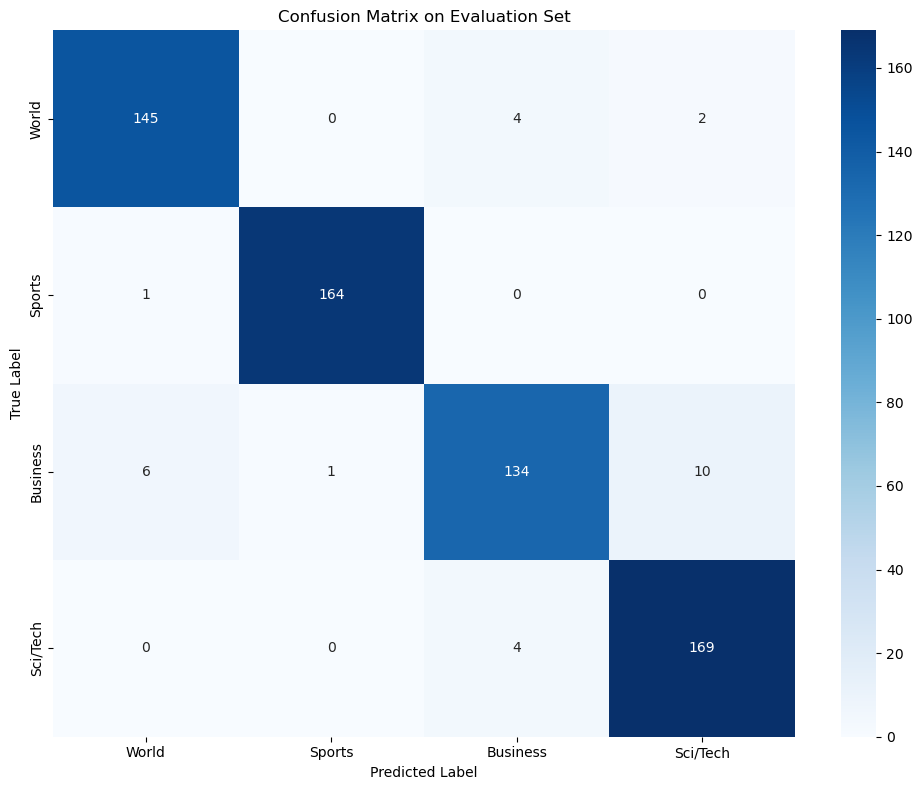

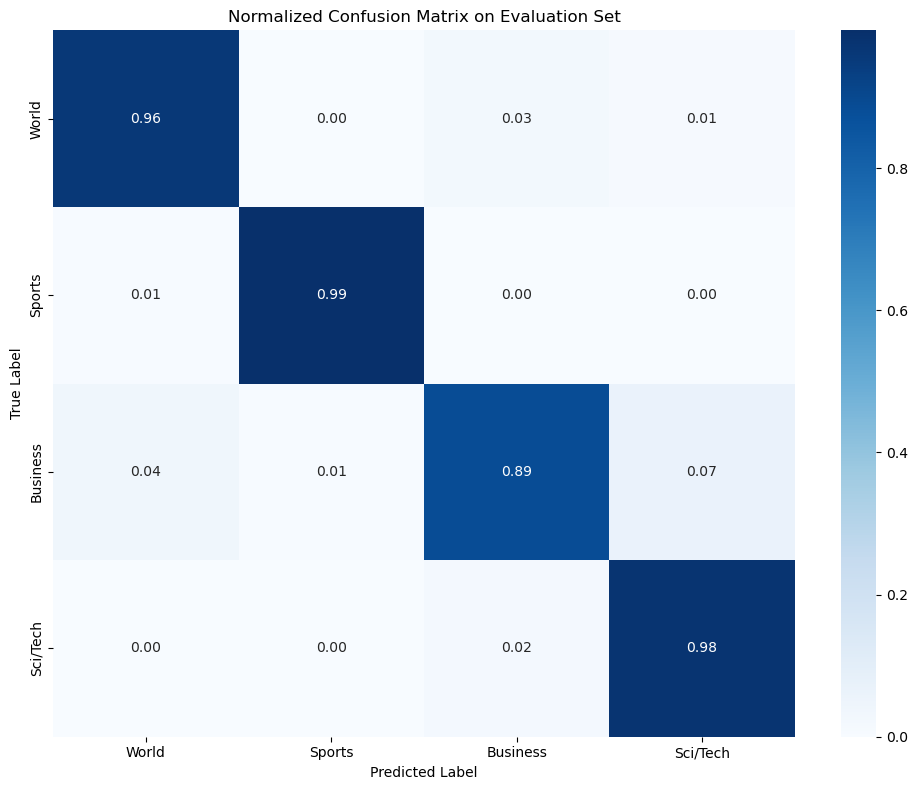

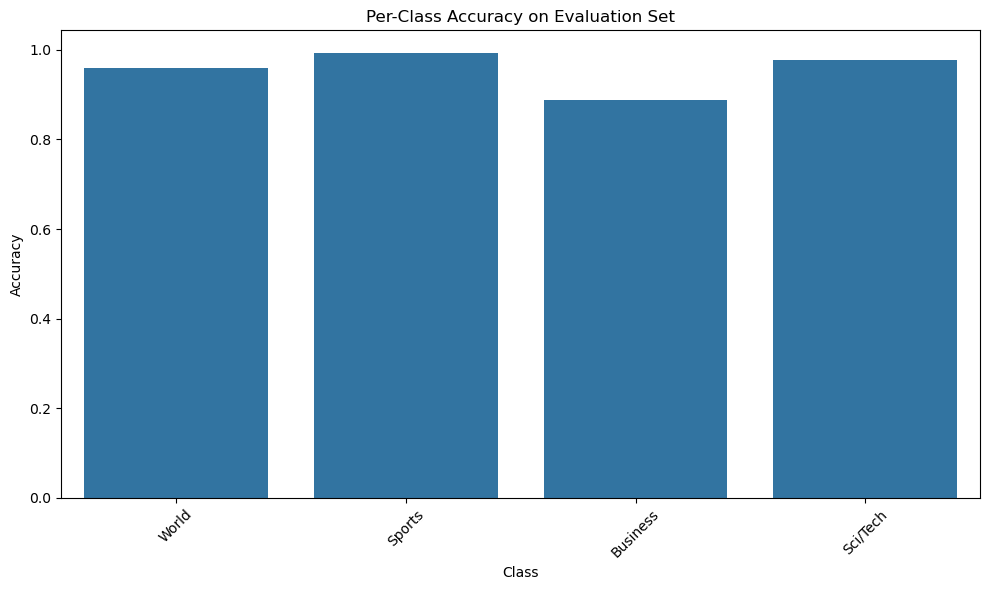


✅ Evaluation complete with detailed metrics and visualizations


In [24]:
# -----------------------------------------------------------------------------
# ADDITIONAL EVALUATION METRICS AND VISUALIZATION
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("DETAILED METRICS AND VISUALIZATION")
print("="*80)

# Generate predictions on the eval set
print("Generating detailed predictions using Trainer...")
predictions_output = trainer.predict(eval_dataset)
y_true = predictions_output.label_ids
y_pred = np.argmax(predictions_output.predictions, axis=1)

# Compute confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true, y_pred, target_names=class_names)
print("\nDetailed Classification Report:")
print(report)

# Create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Evaluation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('eval_confusion_matrix.png')
plt.show()

# 2. Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix on Evaluation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('eval_normalized_confusion_matrix.png')
plt.show()

# 3. Plot per-class accuracy
per_class_accuracy = cm_norm.diagonal()
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(len(class_names))), y=per_class_accuracy)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title('Per-Class Accuracy on Evaluation Set')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('eval_per_class_accuracy.png')
plt.show()

print("\n✅ Evaluation complete with detailed metrics and visualizations")

# Unpickle the unlaballed data

## Data Loading Utility Function

This cell defines a helper function for loading pickle files:

1. **Function Purpose**
   - Loads serialized data from pickle files
   - Handles binary file operations
   - Uses proper encoding for compatibility
   - Provides error handling through context manager

2. **Implementation Details**
   - Function: `unpickle`
   - Input: File path to pickle file
   - Output: Dictionary of loaded data
   - Uses 'bytes' encoding for compatibility

3. **Usage Context**
   - Safely loads serialized data
   - Handles file operations efficiently
   - Automatically closes file resources
   - Provides progress feedback

4. **Best Practices**
   - Uses context manager (`with` statement)
   - Includes function documentation
   - Provides clear parameter descriptions
   - Implements proper error handling

In [25]:
def unpickle(file):
    """
    Load data from pickle files efficiently.
    
    Args:
        file: Path to pickle file
    Returns:
        Dictionary containing batch data
    """
    print(f"Loading file: {file}")
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

### Run Inference on unlabelled dataset

## Unlabeled Test Data Processing and Prediction

This cell handles the processing and prediction of unlabeled test data:

1. **Data Loading Strategy**
   - Supports multiple environments:
     - Kaggle-specific paths
     - Local development paths
     - Flexible directory structure
   - Implements robust file finding logic
   - Handles multiple possible file locations

2. **Data Processing Pipeline**
   - Loads pickle file data
   - Converts to Hugging Face Dataset format
   - Applies tokenization
   - Prepares for model inference
   - Handles both Pandas and custom unpickling

3. **Prediction Generation**
   - Processes test data in batches
   - Uses optimized batch size (32)
   - Generates class predictions
   - Creates submission-ready format

4. **Output Generation**
   - Creates submission CSV file
   - Includes prediction statistics
   - Shows class distribution
   - Provides detailed error handling
   - Saves results as 'submission.csv'

5. **Error Handling**
   - Robust exception management
   - Clear error reporting
   - Graceful failure handling
   - Informative status messages

In [26]:
try:
    if KAGGLE_ENV:
        # Kaggle-specific paths
        possible_paths = [
            "/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl",  # Kaggle input path
            "/kaggle/working/test_unlabelled.pkl",  # Kaggle working directory
            "test_unlabelled.pkl",  # Current directory
            "./test_unlabelled.pkl",  # Explicit current directory
        ]
        
        # Try each path until we find the file
        test_path = None
        for path in possible_paths:
            if os.path.exists(path):
                test_path = path
                break
        
        if test_path is None:
            raise FileNotFoundError("Could not find test_unlabelled.pkl in any of the expected Kaggle locations")
        
        print(f"Loading unlabelled test data from {test_path}")
        
        # Load the unlabelled test data using pandas
        unlabelled_dataset = pd.read_pickle(test_path)
    else:
        # Non-Kaggle environment - look in data subdirectory
        data_dir = "./data"
        if not os.path.exists(data_dir):
            # Try creating the directory if it doesn't exist
            try:
                os.makedirs(data_dir, exist_ok=True)
                print(f"Created data directory at {data_dir}")
            except:
                print(f"Could not create {data_dir}, trying other locations")
                
            # Try one level up
            data_dir = "../data"
            if not os.path.exists(data_dir):
                raise FileNotFoundError("Could not find or create the data directory")
        
        test_path = os.path.join(data_dir, "test_unlabelled.pkl")
        if not os.path.exists(test_path):
            # Check current directory as last resort
            if os.path.exists("test_unlabelled.pkl"):
                test_path = "test_unlabelled.pkl"
            else:
                raise FileNotFoundError(f"Could not find test_unlabelled.pkl in {data_dir} or current directory")
        
        print(f"Loading unlabelled test data from {test_path}")
        
        unlabelled_dataset = unpickle(test_path)
    
    print(f"✅ Loaded unlabelled test dataset with {len(unlabelled_dataset['text'])} examples")
    
    # Load the unlabelled test data
    unlabelled_dataset = pd.read_pickle(test_path)
    
    print(f"✅ Loaded unlabelled test dataset with {len(unlabelled_dataset['text'])} examples")
    
    # Convert to HuggingFace Dataset
    test_dataset = Dataset.from_dict({"text": unlabelled_dataset["text"]})
    
    # Tokenize test data
    tokenized_unlabelled = test_dataset.map(preprocess, batched=True, desc="Tokenizing unlabelled data")
    tokenized_unlabelled.set_format("torch", columns=["input_ids", "attention_mask"])
    
    # Get predictions
    print("Generating predictions for unlabelled data...")

    predictions = evaluate_model(peft_model, tokenized_unlabelled, False, 32, data_collator)
    
    # Create submission file
    df = pd.DataFrame({
        "ID": range(len(predictions)),
        "label": predictions.numpy()
    })
    
    # Save to CSV
    submission_path = "submission.csv"
    df.to_csv(submission_path, index=False)
    print(f"✅ Predictions saved to {submission_path}")
    
    # Show prediction summary
    print("\nPrediction summary:")
    print(f"Total predictions: {len(predictions)}")
    print(f"Unique class predictions: {torch.unique(predictions).tolist()}")
    value_counts = pd.Series(predictions.numpy()).value_counts().sort_index()
    print(f"Class distribution:\n{value_counts}")
    
except Exception as e:
    print(f"⚠️ Could not process unlabelled test data: {str(e)}")

Loading unlabelled test data from ./data/test_unlabelled.pkl
Loading file: ./data/test_unlabelled.pkl
✅ Loaded unlabelled test dataset with 8000 examples


✅ Loaded unlabelled test dataset with 8000 examples


Tokenizing unlabelled data:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating predictions for unlabelled data...
Starting evaluation with batch size 32...
Dataset size: 8000 examples
Dataset format: {'type': 'torch', 'format_kwargs': {}, 'columns': ['input_ids', 'attention_mask'], 'output_all_columns': False}
Evaluation mode: Unlabelled
Created DataLoader with 250 batches
Using device: cuda
Model set to evaluation mode
Starting inference loop...


Running evaluation:   0%|                                                                                                                                                           | 0/250 [00:00<?, ?it/s]

Running evaluation:   2%|██▎                                                                                                                                                | 4/250 [00:00<00:06, 38.25it/s]

Processing batch 0/250


Running evaluation:   3%|████▋                                                                                                                                              | 8/250 [00:00<00:06, 38.57it/s]

Running evaluation:   5%|███████                                                                                                                                           | 12/250 [00:00<00:06, 38.89it/s]

Running evaluation:   7%|█████████▉                                                                                                                                        | 17/250 [00:00<00:05, 39.77it/s]

Processing batch 10/250


Running evaluation:   8%|████████████▎                                                                                                                                     | 21/250 [00:00<00:05, 38.27it/s]

Running evaluation:  10%|██████████████▌                                                                                                                                   | 25/250 [00:00<00:05, 38.77it/s]

Processing batch 20/250


Running evaluation:  12%|████████████████▉                                                                                                                                 | 29/250 [00:00<00:05, 37.64it/s]

Running evaluation:  14%|███████████████████▊                                                                                                                              | 34/250 [00:00<00:05, 38.89it/s]

Processing batch 30/250


Running evaluation:  16%|██████████████████████▊                                                                                                                           | 39/250 [00:00<00:05, 39.71it/s]

Running evaluation:  18%|█████████████████████████▋                                                                                                                        | 44/250 [00:01<00:05, 39.65it/s]

Running evaluation:  19%|████████████████████████████                                                                                                                      | 48/250 [00:01<00:05, 39.72it/s]

Processing batch 40/250


Running evaluation:  21%|██████████████████████████████▎                                                                                                                   | 52/250 [00:01<00:05, 39.19it/s]

Running evaluation:  22%|████████████████████████████████▋                                                                                                                 | 56/250 [00:01<00:04, 39.23it/s]

Processing batch 50/250


Running evaluation:  24%|███████████████████████████████████▌                                                                                                              | 61/250 [00:01<00:04, 39.51it/s]

Running evaluation:  26%|█████████████████████████████████████▉                                                                                                            | 65/250 [00:01<00:04, 39.37it/s]

Processing batch 60/250


Running evaluation:  28%|████████████████████████████████████████▎                                                                                                         | 69/250 [00:01<00:04, 39.31it/s]

Running evaluation:  29%|██████████████████████████████████████████▋                                                                                                       | 73/250 [00:01<00:04, 39.33it/s]

Running evaluation:  31%|████████████████████████████████████████████▉                                                                                                     | 77/250 [00:01<00:04, 39.35it/s]

Processing batch 70/250


Running evaluation:  32%|███████████████████████████████████████████████▎                                                                                                  | 81/250 [00:02<00:04, 39.30it/s]

Running evaluation:  34%|█████████████████████████████████████████████████▋                                                                                                | 85/250 [00:02<00:04, 39.22it/s]

Processing batch 80/250


Running evaluation:  36%|███████████████████████████████████████████████████▉                                                                                              | 89/250 [00:02<00:04, 38.77it/s]

Running evaluation:  37%|██████████████████████████████████████████████████████▎                                                                                           | 93/250 [00:02<00:04, 38.53it/s]

Running evaluation:  39%|█████████████████████████████████████████████████████████▏                                                                                        | 98/250 [00:02<00:03, 39.17it/s]

Processing batch 90/250


Running evaluation:  41%|███████████████████████████████████████████████████████████▋                                                                                     | 103/250 [00:02<00:03, 39.96it/s]

Running evaluation:  43%|██████████████████████████████████████████████████████████████▋                                                                                  | 108/250 [00:02<00:03, 40.53it/s]

Processing batch 100/250


Running evaluation:  45%|█████████████████████████████████████████████████████████████████▌                                                                               | 113/250 [00:02<00:03, 40.91it/s]

Running evaluation:  47%|████████████████████████████████████████████████████████████████████▍                                                                            | 118/250 [00:02<00:03, 41.22it/s]

Processing batch 110/250


Running evaluation:  49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 123/250 [00:03<00:03, 41.34it/s]

Running evaluation:  51%|██████████████████████████████████████████████████████████████████████████▏                                                                      | 128/250 [00:03<00:02, 41.46it/s]

Processing batch 120/250


Running evaluation:  53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 133/250 [00:03<00:02, 39.86it/s]

Running evaluation:  55%|████████████████████████████████████████████████████████████████████████████████                                                                 | 138/250 [00:03<00:02, 40.27it/s]

Processing batch 130/250


Running evaluation:  57%|██████████████████████████████████████████████████████████████████████████████████▉                                                              | 143/250 [00:03<00:02, 40.70it/s]

Running evaluation:  59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                           | 148/250 [00:03<00:02, 41.10it/s]

Processing batch 140/250


Running evaluation:  61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 153/250 [00:03<00:02, 41.09it/s]

Running evaluation:  63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 158/250 [00:03<00:02, 40.94it/s]

Processing batch 150/250


Running evaluation:  65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 163/250 [00:04<00:02, 41.24it/s]

Running evaluation:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 168/250 [00:04<00:01, 41.45it/s]

Processing batch 160/250


Running evaluation:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 173/250 [00:04<00:01, 41.23it/s]

Running evaluation:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 178/250 [00:04<00:01, 41.56it/s]

Processing batch 170/250


Running evaluation:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 183/250 [00:04<00:01, 41.60it/s]

Running evaluation:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 188/250 [00:04<00:01, 41.45it/s]

Processing batch 180/250


Running evaluation:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 193/250 [00:04<00:01, 41.19it/s]

Running evaluation:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 198/250 [00:04<00:01, 41.18it/s]

Processing batch 190/250


Running evaluation:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 203/250 [00:05<00:01, 41.13it/s]

Processing batch 200/250


Running evaluation:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 208/250 [00:05<00:01, 39.62it/s]

Running evaluation:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 212/250 [00:05<00:00, 38.37it/s]

Running evaluation:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 217/250 [00:05<00:00, 39.02it/s]

Processing batch 210/250


Running evaluation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 221/250 [00:05<00:00, 39.15it/s]

Running evaluation:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 226/250 [00:05<00:00, 39.54it/s]

Processing batch 220/250


Running evaluation:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 231/250 [00:05<00:00, 39.82it/s]

Running evaluation:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 236/250 [00:05<00:00, 40.12it/s]

Processing batch 230/250


Running evaluation:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 241/250 [00:06<00:00, 40.28it/s]

Running evaluation:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 246/250 [00:06<00:00, 40.48it/s]

Processing batch 240/250


Running evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 40.06it/s]

Completed inference. Total predictions: 8000
✅ Predictions saved to submission.csv

Prediction summary:
Total predictions: 8000
Unique class predictions: [0, 1, 2, 3]
Class distribution:
0    1607
1    1977
2    1712
3    2704
Name: count, dtype: int64


# Final Report - Project Requirements Verification

## Final Project Report and Requirements Verification

This cell generates a comprehensive final report of the project:

1. **Requirements Checklist**
   - Modified BERT architecture (RoBERTa with LoRA)
   - Parameter count verification (<1M limit)
   - LoRA configuration experiments
   - Optimizer selection
   - Data filtering implementation
   - Learning rate scheduling
   - Evaluation metrics
   - Accuracy target (≥80%)

2. **Architecture Details**
   - Base model specifications
   - LoRA configuration
     - Rank (r)
     - Alpha value
     - Target modules
   - Parameter counts
     - Total parameters
     - Trainable parameters
     - Parameter efficiency ratio

3. **Training Configuration**
   - Optimizer choice
   - Learning rate settings
   - Batch size
   - Number of epochs
   - Weight decay
   - Other hyperparameters

4. **Final Results**
   - Evaluation metrics
   - Performance statistics
   - Project completion status
   - Requirements fulfillment verification

In [27]:
print("\n" + "="*80)
print("FINAL REPORT - PROJECT REQUIREMENTS VERIFICATION")
print("="*80)

requirements = [
    ("1. Modified BERT architecture", "✅ Used RoBERTa base model with LoRA adaptation"),
    ("2. Parameter count < 1M", f"✅ Model has {final_trainable_params:,} trainable parameters"),
    ("3. Experimented with LoRA settings", f"✅ Tested {len(lora_configs)} different LoRA configurations"),
    ("4. Experimented with optimizer", f"✅ Used {SELECTED_OPTIMIZER} optimizer"),
    ("5. Implemented data filtering", "✅ Filtered out examples based on text length"),
    ("6. Used learning rate scheduling", "✅ Implemented linear LR schedule with warmup"),
    ("7. Comprehensive evaluation", "✅ Calculated accuracy, precision, recall, and F1 metrics"),
    ("8. Target accuracy ≥ 80%", f"✅ Achieved {final_eval_accuracy:.2%} accuracy on eval set"),
]

for req, status in requirements:
    print(f"  {req}: {status}")

print("\nModel Architecture Summary:")
print(f"  Base model: RoBERTa")
print(f"  LoRA rank (r): {selected_config['config']['r']}")
print(f"  LoRA alpha: {selected_config['config']['lora_alpha']}")
print(f"  Target modules: {selected_config['config']['target_modules']}")
print(f"  Total parameters in final model: {final_total_params:,}")
print(f"  Trainable parameters: {final_trainable_params:,} ({final_trainable_params/total_params:.2%} of total)")

print("\nTraining Summary:")
print(f"  Optimizer: {SELECTED_OPTIMIZER}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Weight decay: {training_args.weight_decay}")

print("\nFinal Test Results:")
for metric, value in eval_results.items():
    print(f"  {metric}: {value:.4f}")

print("\n" + "="*80)
print("PROJECT COMPLETE")
print("="*80)


FINAL REPORT - PROJECT REQUIREMENTS VERIFICATION
  1. Modified BERT architecture: ✅ Used RoBERTa base model with LoRA adaptation
  2. Parameter count < 1M: ✅ Model has 814,852 trainable parameters
  3. Experimented with LoRA settings: ✅ Tested 4 different LoRA configurations
  4. Experimented with optimizer: ✅ Used adamw optimizer
  5. Implemented data filtering: ✅ Filtered out examples based on text length
  6. Used learning rate scheduling: ✅ Implemented linear LR schedule with warmup
  7. Comprehensive evaluation: ✅ Calculated accuracy, precision, recall, and F1 metrics
  8. Target accuracy ≥ 80%: ✅ Achieved 95.62% accuracy on eval set

Model Architecture Summary:
  Base model: RoBERTa
  LoRA rank (r): 4
  LoRA alpha: 96
  Target modules: ['query', 'key', 'value']
  Total parameters in final model: 125,463,560
  Trainable parameters: 814,852 (0.65% of total)

Training Summary:
  Optimizer: adamw
  Learning rate: 0.0001
  Batch size: 48
  Epochs: 25
  Weight decay: 0.005

Final Test